# Opinion Detection - Supervised

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn

import nltk
nltk.download('movie_reviews')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


### <font color='orange'>Load and Preprocess Data</font>

In [2]:
from nltk.corpus import movie_reviews as mr
from random import shuffle, seed
seed(42)

documents = [(mr.raw(file_id), 1 if category == 'pos' else 0) for category in mr.categories() for file_id in mr.fileids(category)]
shuffle(documents)

In [3]:
df_train, df_test = documents[:1600], documents[1600:]
X_train = [item[0] for item in df_train]
y_train = [item[1] for item in df_train]

X_test = [item[0] for item in df_test]
y_test = [item[1] for item in df_test]

In [4]:
X_train_cleaned = tn.normalize_corpus(X_train)
X_test_cleaned = tn.normalize_corpus(X_test)
pd.DataFrame(X_train_cleaned).to_csv('datasets/X_train_cleaned.csv', index=False)
pd.DataFrame(X_test_cleaned).to_csv('datasets/X_test_cleaned.csv', index=False)

### <font color='orange'>Feature Extraction</font>

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# build BOW features on train reviews
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
cv_train_features = cv.fit_transform(X_train_cleaned)

# transform test reviews into features
cv_test_features = cv.transform(X_test_cleaned)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (1600, 41931)  Test features shape: (400, 41931)


### <font color='orange'>Model Training, Prediction and Performance Evaluation</font>

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [49]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10]}

lr = LogisticRegression(max_iter = 100, random_state = 42)
lr_grid_search = GridSearchCV(lr, parameters, cv = 10, scoring='accuracy')
lr_grid_search.fit(cv_train_features, y_train)

predictions = lr_grid_search.predict(cv_test_features) 

In [51]:
score = lr_grid_search.score(cv_test_features, y_test)
print("Accuracy score:",np.round(score, 2)*100,"%")

Accuracy score: 84.0 %


Confusion matrix:


Text(0.5, 1.0, 'Accuracy Score: 84.0%')

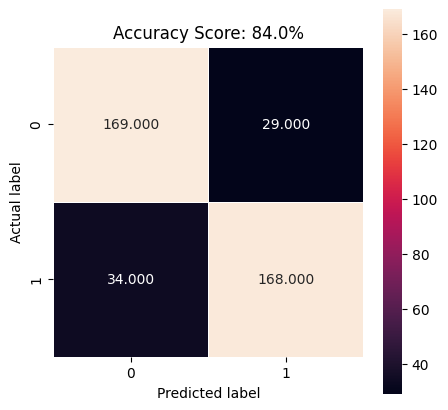

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
all_sample_title = 'Accuracy Score: {0}%'.format(np.round(score,2)*100)
plt.title(all_sample_title, size = 12)

### LightGBM

In [28]:
cv_train_features_float = cv_train_features.astype('float32')

In [40]:
clf = lgb.LGBMClassifier(random_state=42)


In [30]:
clf.fit(cv_train_features_float, y_train)

[LightGBM] [Info] Number of positive: 798, number of negative: 802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14368
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 3771
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498750 -> initscore=-0.005000
[LightGBM] [Info] Start training from score -0.005000


LGBMClassifier()

In [31]:
cv_test_features_float = cv_test_features.astype('float32')

In [32]:
predictions_lgbm = clf.predict(cv_test_features_float) 

Confusion matrix:


Text(0.5, 1.0, 'Accuracy Score: 84.0%')

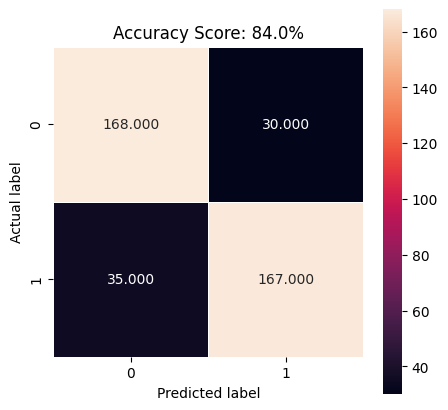

In [33]:
from sklearn.metrics import accuracy_score

score_lgbm = accuracy_score(y_test, predictions_lgbm)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions_lgbm)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
all_sample_title = 'Accuracy Score: {0}%'.format(np.round(score_lgbm,2)*100)
plt.title(all_sample_title, size = 12)

### Feature Importance

<Axes: >

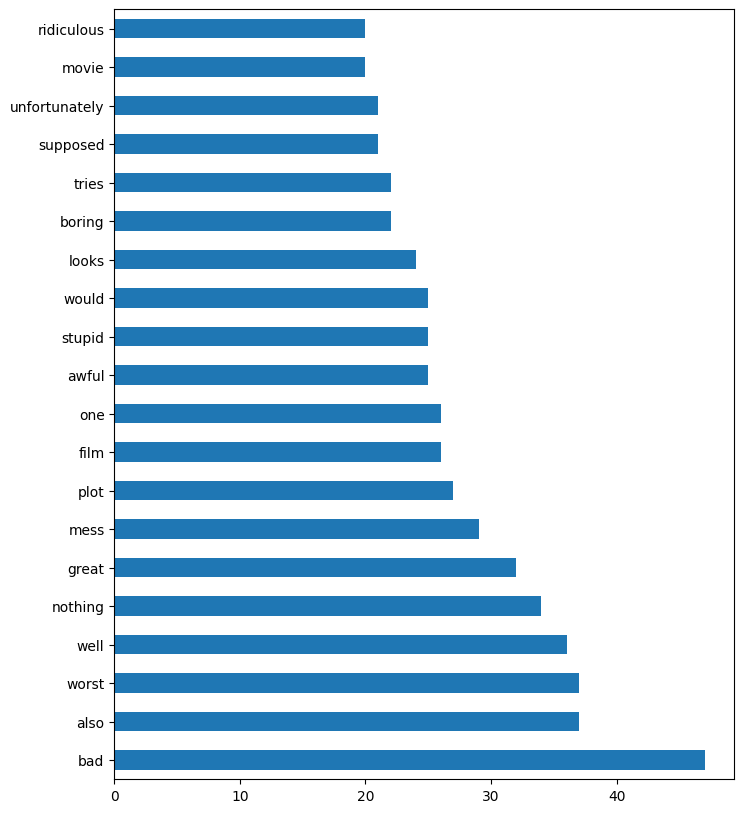

In [34]:
feat_imp = pd.Series(clf.feature_importances_, index=cv.get_feature_names_out())
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

## Feature engineering


### Dimensionality reduction

In [35]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, SparsePCA
from nltk import pos_tag
from nltk.tag import StanfordNERTagger

In [36]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)

X_train_svd = svd.fit_transform(cv_train_features)
X_test_svd = svd.transform(cv_test_features)

In [41]:
clf_svd = lgb.LGBMClassifier(random_state=42)
clf_svd.fit(X_train_svd, y_train)
pred_svd = clf_svd.predict(X_test_svd)
acc_svd = accuracy_score(y_test, pred_svd)
print(acc_svd)

[LightGBM] [Info] Number of positive: 798, number of negative: 802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498750 -> initscore=-0.005000
[LightGBM] [Info] Start training from score -0.005000
0.735


### PCA

In [43]:
spca = SparsePCA(n_components=10, random_state=42)

X_train_spca = spca.fit_transform(X_train_svd)
X_test_spca = spca.transform(X_test_svd)

In [44]:
clf_pca = lgb.LGBMClassifier(random_state=42)
clf_pca.fit(X_train_spca, y_train)
pred_pca = clf_pca.predict(X_test_spca)
acc_pca = accuracy_score(y_test, pred_pca)
print(acc_pca)

[LightGBM] [Info] Number of positive: 798, number of negative: 802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498750 -> initscore=-0.005000
[LightGBM] [Info] Start training from score -0.005000
0.635


## Fature extraction

In [45]:
def count_words(text):
    return len(str(text).split())

def count_uniquewords(text):
    return len(set(str(text).split()))

def count_chars(text):
    return len(str(text))

def word_density(text):
    return count_chars(text) / (count_words(text) + 1)

def count_firstwords(text):
    """count first word of sentence"""
    firstwords = re.findall(r"\b[A-Z][a-z]+\b", str(text))
    return firstwords

In [50]:
from flaml.default import LGBMClassifier

clf_hyp = LGBMClassifier()
clf_hyp.fit(cv_train_features_float)

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'njobs'